In [1]:
import geopandas as gpd
import geemap, ee
import os
import gdown
from random import randrange
import json
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show, adjust_band

from model.model import UNet
from scripts.raster_preparation import clip_raster, get_raster_mask, build_grid, clip_to_patches, build_mask_patches, get_vector_mask
from scripts.get_raster_data import SEN2_downloader
import torch


%load_ext autoreload
%autoreload 2


следующий блок кода запускать необязательно - это авторизация в системе Google earth engine 

In [36]:
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


ниже будет изложен пример предподготовки данных, использования модели и последующей постподготовки данных (сборки масок полученных из нейронной сети обратно векторное представление)

### Вектор
для начала возьмем рандомный вектор (в нашем случае вектор создан в q-gis)

<AxesSubplot:>

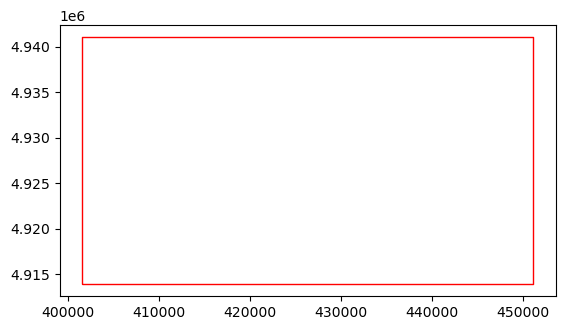

In [12]:
example_boundary = gpd.read_file('./data/geoms/example_geometry.geojson')
example_boundary.plot(facecolor='none' ,edgecolor = 'r')

<AxesSubplot:>

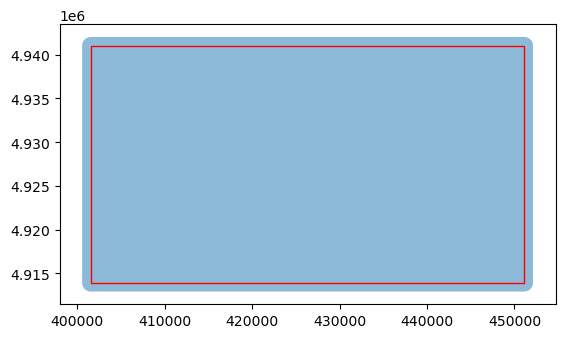

In [31]:
example_buffered =  gpd.GeoDataFrame(geometry = example_boundary.buffer(1000)) #для удобства создадим полигон с буфером в 1000 метров
ax = example_buffered.plot(alpha = 0.5)
example_boundary.plot(facecolor='none' ,edgecolor = 'r', ax = ax)

необходимо получить растровые данные 

In [45]:
if not os.path.exists('./data/input_raster/example_raster.tif'):
    get_data = SEN2_downloader('2022', example_buffered) #здесь мы будем скачивать данные с небольшим запасом - создав буфер к нашему вектору по 500 метров
    get_data.get_collection()
    geemap.download_ee_image(get_data.rgb_nir, './data/input_raster/example_raster.tif', region = geemap.geopandas_to_ee(example_buffered).geometry())
    print('скачивание закончено ')
else:
    print('file exists')

example_raster.tif: |          | 0.00/505M (raw) [  0.0%] in 00:00 (eta:     ?)

скачивание закончено 


альтернативный вариант получения растра это скачать приведенный пример по данной ссылке ниже

In [98]:
if not os.path.exists('./data/input_raster/example_raster.tif'):
    url = "https://drive.google.com/file/d/1Jdiixjacn7dhsO42RyhQPNtEUBKYC-aJ/view?usp=sharing"
    output = './data/input_raster/example_raster.tif'

    gdown.download(url, output, quiet=False)
else:
    print('file exists')


file exists


Так как растр имеет довольно большой вес (>100mb) его проще отобразить как обычное изображение
<img src="./images/тестовый растр.png" alt="Текст" />


### векторная решетка 
для того чтобы равномерно нарезать полученный раст необходимо создать сетку квадратов по которым будет осуществлятся нарезка исходного растра 

<AxesSubplot:>

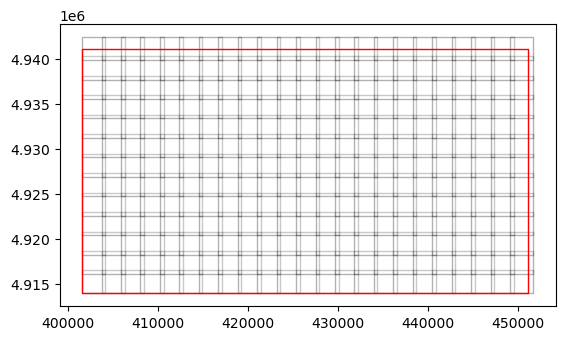

In [48]:
grid = build_grid(example_boundary, 2560, 400)

ax = grid.plot(edgecolor = 'black', alpha = 0.3, color = 'w')
example_boundary.plot(ax=ax, facecolor='none' ,edgecolor = 'r')


### режем датасет

In [51]:
clip_to_patches("./data/input_raster/example_raster.tif",grid)

100%|██████████| 299/299 [00:12<00:00, 23.23it/s]


кроме нарезанных участков растра создан json файл в котором хранится мета информация о каждом участке (проекция и трансформация)

In [72]:
json_dir = "./data/temp/patches_meta.json"
meta_json = open(json_dir, mode='r')
meta_json = json.load(meta_json)
patches_count = len(meta_json['data'])

for i in range(5):
    random_num = randrange(patches_count)
    print(meta_json['data'][random_num])



{'FID': 298, 'metadata': {'driver': 'GTiff', 'height': 256, 'width': 256, 'transform': [10.0, 0.0, 449090.0, 0.0, -10.0, 4942410.0, 0.0, 0.0, 1.0], 'crs': 32638, 'nodata': 0, 'dtype': 'uint16'}, 'file_location': './data/temp/raster_patches/298.tif'}
{'FID': 278, 'metadata': {'driver': 'GTiff', 'height': 256, 'width': 256, 'transform': [10.0, 0.0, 405890.0, 0.0, -10.0, 4942410.0, 0.0, 0.0, 1.0], 'crs': 32638, 'nodata': 0, 'dtype': 'uint16'}, 'file_location': './data/temp/raster_patches/278.tif'}
{'FID': 119, 'metadata': {'driver': 'GTiff', 'height': 256, 'width': 256, 'transform': [10.0, 0.0, 410210.0, 0.0, -10.0, 4927290.0, 0.0, 0.0, 1.0], 'crs': 32638, 'nodata': 0, 'dtype': 'uint16'}, 'file_location': './data/temp/raster_patches/119.tif'}
{'FID': 293, 'metadata': {'driver': 'GTiff', 'height': 256, 'width': 256, 'transform': [10.0, 0.0, 438290.0, 0.0, -10.0, 4942410.0, 0.0, 0.0, 1.0], 'crs': 32638, 'nodata': 0, 'dtype': 'uint16'}, 'file_location': './data/temp/raster_patches/293.tif'}


Сами разрезанные участки растра выглядят следующим образом - сверху отображены изображения в видимом спектре, снизу в инфракрасном + красном + зеленом

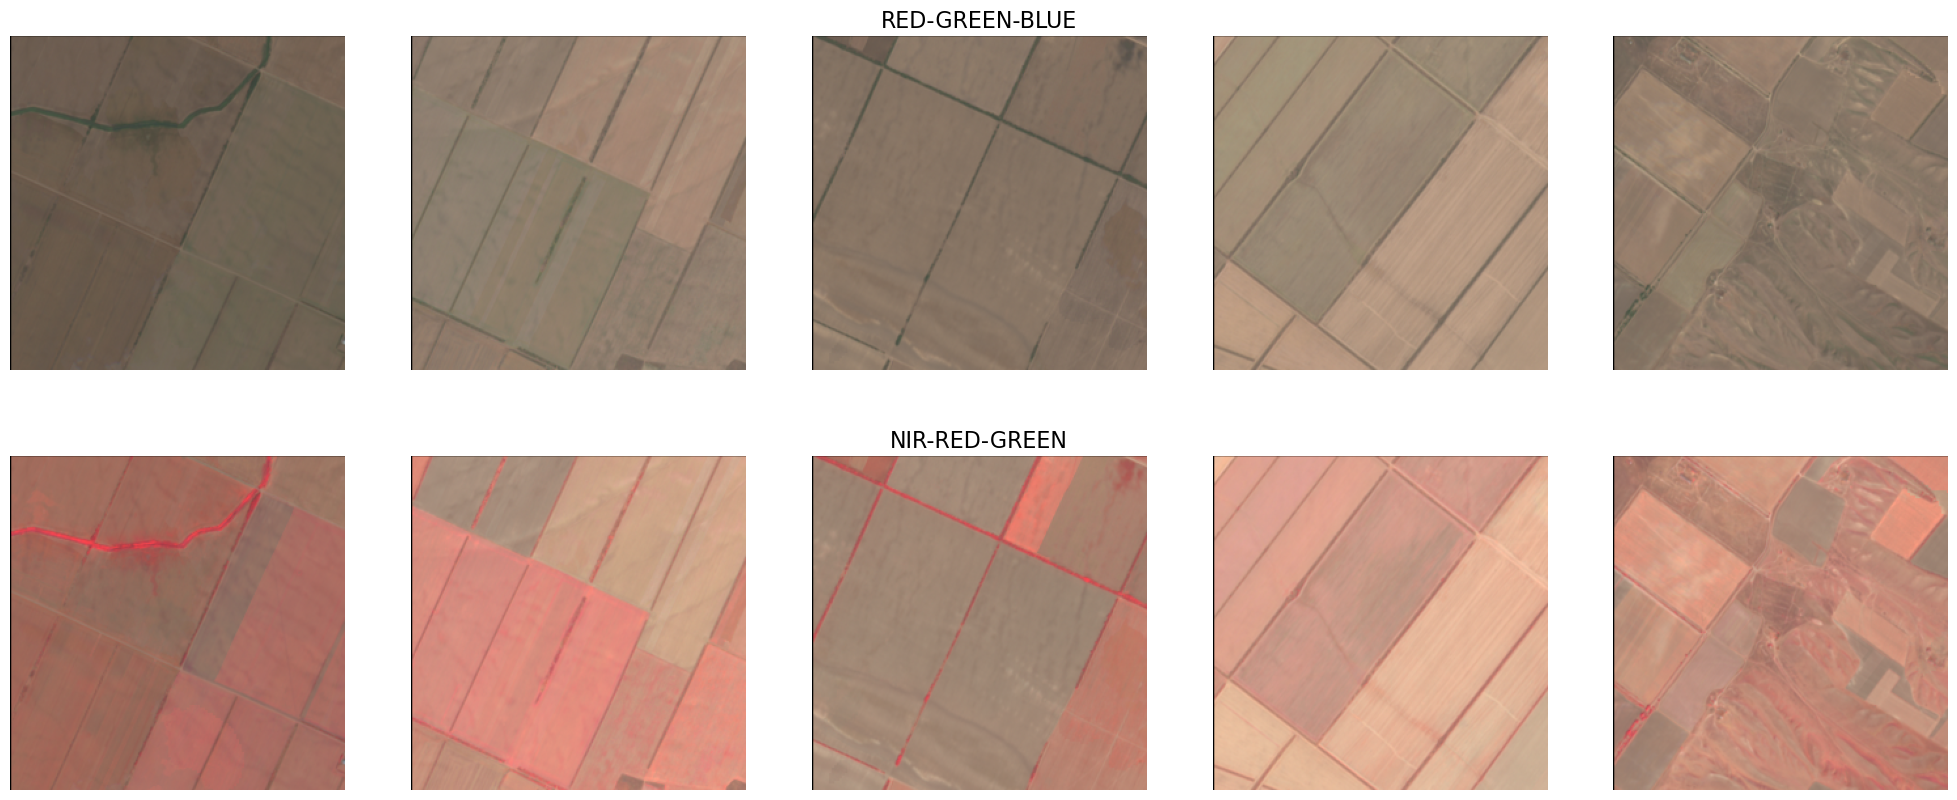

In [97]:
fig, axes = plt.subplots(2,5, figsize=(25,10)) 
for i in range(5):
    random_num = randrange(patches_count)
    patch_dir = meta_json['data'][random_num]['file_location']
    raster = rasterio.open(patch_dir)
    normalized = adjust_band(raster.read())
    show(normalized[0:3], ax = axes[0,i])
    show(normalized[[3,0,1]], ax = axes[1,i])
    axes[1,i].axis('off')
    axes[0,i].axis('off')
    axes[0,2].set_title('RED-GREEN-BLUE', fontsize = 16)
    axes[1,2].set_title('NIR-RED-GREEN', fontsize = 16)


### Модель
модель полученная на кагде а именно ее веса так же выложены на гугл диске по ссылке 

In [99]:
if not os.path.exists('./model/model_state.pt'):
    url = "https://drive.google.com/file/d/1EBTpVOHb_umhBVS0maqKuwlOmhJwdzsu/view?usp=sharing"
    output = './model/model_state.pt'

    gdown.download(url, output, quiet=False)
else:
    print('file exists')

file exists


теперь подгрузим модель и передадим ее функции которая прогоняет ранее полученные участки патчей, собирает в единый большой растр и векторизует итоговое изображение

In [100]:

model = UNet()
model.load_state_dict(torch.load("./model/model_state.pt"))


<All keys matched successfully>

применение сети для сегментации...


100%|██████████| 299/299 [00:46<00:00,  6.38it/s]


собираем общий растр...


100%|██████████| 299/299 [00:00<00:00, 597.17it/s]


<AxesSubplot:>

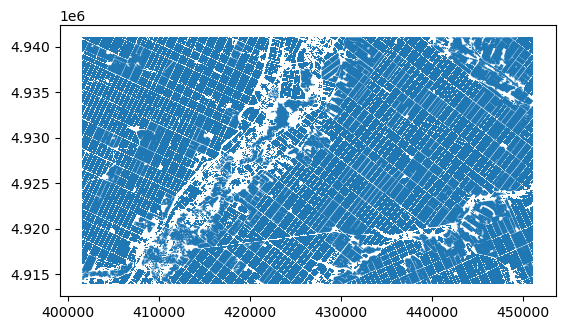

In [101]:
result = get_vector_mask("./data/temp/patches_meta.json", model, example_boundary)
result.to_file('./data/output_vector/result.geojson', driver = 'GeoJSON')
result.plot()




Резюме:модель на обучении и валидации показала точность около 97 процентов, ниже приведена уже оформленная карта (чтобы продемонстрировать работу программы) полученные материалы уже имеют географическую привязку и являются базой для дальнейшей работы. На карте видны недостатки работы модели - зачастую сеть определяла лесные масивы как с/х поля, возможно требуется проведение не бинарной а много классовой сегментации, однако решенее это задачи требует более трудоемкой работы по разметке первоначального датасета используемого для обучения 
<img src="./images/stav_deep_learning_map_result.png" alt="Текст" />
